In [1]:
# 依赖安装（不包含任何字体设置）
import sys, subprocess
for pkg in ("pandas", "numpy", "matplotlib", "seaborn", "scikit-learn", "statsmodels"):
    try:
        __import__(pkg); print(f"{pkg} 已安装")
    except ImportError:
        print(f"正在安装 {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])


pandas 已安装
numpy 已安装
matplotlib 已安装
seaborn 已安装
正在安装 scikit-learn ...
statsmodels 已安装


中文字体启用： Noto Sans SC


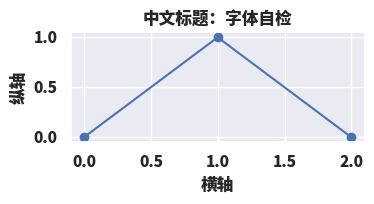

In [2]:
# --- 中文字体离线配置（使用本地 NotoSansSC-Black.ttf） ---
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams
import seaborn as sns
from pathlib import Path

# 本地字体文件（请将 NotoSansSC-Black.ttf 放在 Notebook 同目录）
FONT_FILE = Path("NotoSansSC-Black.ttf")

if not FONT_FILE.exists():
    raise FileNotFoundError(f"请把 {FONT_FILE} 放到当前目录下")

# 注册并获取字体名称
fm.fontManager.addfont(str(FONT_FILE.resolve()))
FONT_NAME = fm.FontProperties(fname=str(FONT_FILE.resolve())).get_name()

# 设置 Matplotlib & Seaborn 默认字体
rcParams["font.family"] = [FONT_NAME]
rcParams["axes.unicode_minus"] = False
sns.set_theme(font=FONT_NAME, rc={"axes.unicode_minus": False})

print("中文字体启用：", FONT_NAME)

# --- 验证 ---
plt.figure(figsize=(4,2.2))
plt.title("中文标题：字体自检")
plt.xlabel("横轴")
plt.ylabel("纵轴")
plt.plot([0,1,2],[0,1,0], "o-")
plt.tight_layout()
plt.show()


In [3]:
# 辅助：若未定义 df，则创建一个演示用 df（含 churn 标签）
import numpy as np, pandas as pd
def ensure_demo_df(n=500, p=10, seed=42):
    rng = np.random.default_rng(seed)
    X = rng.normal(size=(n, p))
    cols = [f"f{i+1}" for i in range(p)]
    df = pd.DataFrame(X, columns=cols)
    logits = 0.5*X[:,0] - 0.8*X[:,1] + 0.3*X[:,2]
    prob = 1/(1+np.exp(-logits))
    df['churn'] = (rng.random(n) < prob).astype(int)
    return df
if 'df' not in globals():
    df = ensure_demo_df()
    print("已自动创建演示 df（含 'churn' 与 10 个特征 f1..f10）。")


已自动创建演示 df（含 'churn' 与 10 个特征 f1..f10）。


In [6]:
# --- Example 1 ---
# --- 导入库 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# --- 设置随机种子以保证结果可复现 ---
np.random.seed(42)

# --- 生成模拟的流失数据 ---
n_samples = 2000
data = {
    'tenure': np.random.randint(1, 73, n_samples),
    'monthly_charges': np.random.uniform(20, 120, n_samples),
    'is_senior_citizen': np.random.choice([0, 1], n_samples, p=[0.84, 0.16]),
    'contract_month_to_month': np.random.choice([0, 1], n_samples, p=[0.45, 0.55]),
    'has_fiber_optic': np.random.choice([0, 1], n_samples, p=[0.5, 0.5]),
}
df = pd.DataFrame(data)

# 使用 logit 模型结构创建模拟的流失概率
churn_log_odds = (
    -2.8
    - 0.07 * df['tenure']
    + 0.03 * df['monthly_charges']
    + 0.4 * df['is_senior_citizen']
    + 1.8 * df['contract_month_to_month']
    + 0.9 * df['has_fiber_optic']
    + np.random.normal(0, 1.2, n_samples)  # 加入随机噪声
)
churn_prob = 1 / (1 + np.exp(-churn_log_odds))
df['churn'] = (churn_prob > 0.5).astype(int)

print("--- 数据集头部信息 ---")
print(df.head())
print("\n--- 流失分布情况 ---")
print(df['churn'].value_counts(normalize=True))


--- 数据集头部信息 ---
   tenure  monthly_charges  is_senior_citizen  contract_month_to_month  \
0      52       100.153711                  0                        0   
1      15       115.957664                  0                        1   
2      72        68.785404                  0                        0   
3      61        30.973620                  0                        0   
4      21        74.795949                  0                        0   

   has_fiber_optic  churn  
0                1      0  
1                0      1  
2                1      0  
3                1      0  
4                0      0  

--- 流失分布情况 ---
churn
0    0.7605
1    0.2395
Name: proportion, dtype: float64


In [8]:
# --- Example 2 ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- 定义特征 (X) 和目标 (y) ---
X = df.drop('churn', axis=1)
y = df['churn']

# --- 将数据拆分为训练集和测试集 ---
# 使用 stratify=y 确保训练集和测试集中流失用户的比例相同
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# --- 对数值特征进行缩放 ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n训练集形状: {X_train_scaled.shape}")
print(f"测试集形状: {X_test_scaled.shape}")



训练集形状: (1500, 5)
测试集形状: (500, 5)


In [9]:
# --- Example 3 ---
# --- 初始化并训练模型 ---
log_reg = LogisticRegression(random_state=42, solver='liblinear')
log_reg.fit(X_train_scaled, y_train)

# --- 进行预测 ---
y_pred = log_reg.predict(X_test_scaled)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1] # 类别为'1'的概率

# --- 评估性能 ---
print("\n--- 模型评估 ---")
print(f"测试集准确率: {accuracy_score(y_test, y_pred):.4f}")

# 分类报告提供了关键指标
print("\n--- 分类报告 ---")
print(classification_report(y_test, y_pred, target_names=['未流失', '流失']))


--- 模型评估 ---
测试集准确率: 0.8640

--- 分类报告 ---
              precision    recall  f1-score   support

         未流失       0.89      0.93      0.91       380
          流失       0.75      0.64      0.69       120

    accuracy                           0.86       500
   macro avg       0.82      0.79      0.80       500
weighted avg       0.86      0.86      0.86       500



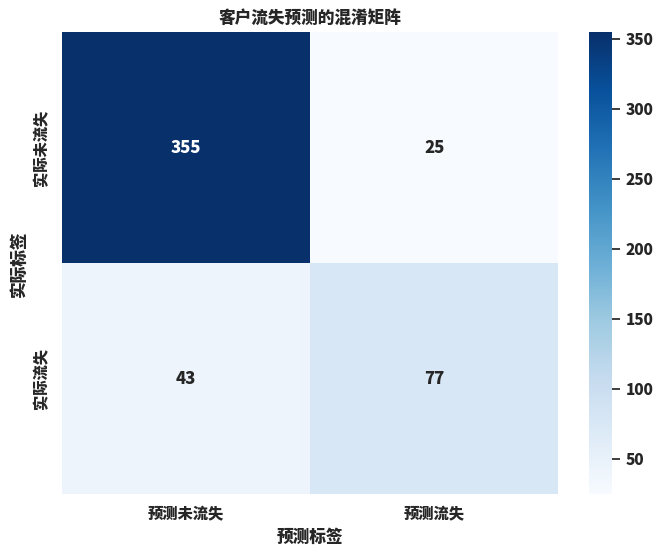

In [10]:
# --- Example 4 ---
# --- 显示并解读混淆矩阵 ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['预测未流失', '预测流失'],
            yticklabels=['实际未流失', '实际流失'])
plt.title('客户流失预测的混淆矩阵')
plt.ylabel('实际标签')
plt.xlabel('预测标签')
plt.show()

In [13]:
# --- Example 5 (修复版): 系数与赔率比 ---

import numpy as np
import pandas as pd

coef = np.asarray(log_reg.coef_)  # shape: (n_classes, n_features)
intercept = np.asarray(log_reg.intercept_)  # shape: (n_classes,)

if coef.ndim == 2 and coef.shape[0] == 1:
    # 二分类：将 (1, n_features) 展平成 (n_features,)
    coef_1d = coef.ravel()
    coefficients = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient (Log-Odds)': coef_1d
    })
    coefficients['Odds Ratio'] = np.exp(coefficients['Coefficient (Log-Odds)'])
    coefficients = coefficients.sort_values(by='Odds Ratio', ascending=False).reset_index(drop=True)

    print("\n--- 模型系数与赔率比（二分类）---")
    print(coefficients)

    # 如需查看截距（对应 log-odds 基准项）：
    print(f"\nIntercept (log-odds): {intercept[0]:.4f}  |  Intercept OR: {np.exp(intercept[0]):.4f}")

else:
    # 多分类（One-vs-Rest）：为每个类别输出一张表
    rows = []
    for cls_idx, w in enumerate(coef):
        df_cls = pd.DataFrame({
            'Class': cls_idx,
            'Feature': X.columns,
            'Coefficient (Log-Odds)': w
        })
        df_cls['Odds Ratio'] = np.exp(df_cls['Coefficient (Log-Odds)'])
        rows.append(df_cls.sort_values(by='Odds Ratio', ascending=False))
    coefficients = pd.concat(rows, ignore_index=True)

    print("\n--- 模型系数与赔率比（多分类）---")
    print(coefficients)

    # 截距（每个类别一个）
    for cls_idx, b0 in enumerate(intercept):
        print(f"Class {cls_idx} Intercept (log-odds): {b0:.4f}  |  Intercept OR: {np.exp(b0):.4f}")



--- 模型系数与赔率比（二分类）---
                   Feature  Coefficient (Log-Odds)  Odds Ratio
0  contract_month_to_month                1.312547    3.715624
1          monthly_charges                1.177847    3.247374
2          has_fiber_optic                0.468824    1.598114
3        is_senior_citizen                0.194832    1.215107
4                   tenure               -1.907730    0.148417

Intercept (log-odds): -2.3591  |  Intercept OR: 0.0945


In [14]:
# --- Example 6 ---
# --- 使用GridSearchCV进行超参数调优 ---
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(
    LogisticRegression(random_state=42, solver='liblinear'),
    param_grid,
    cv=5, # 5折交叉验证
    scoring='f1' # 此处以F1分数为优化目标
)
grid_search.fit(X_train_scaled, y_train)

print(f"\nGridSearchCV找到的最佳超参数C: {grid_search.best_params_}")
best_model = grid_search.best_estimator_


GridSearchCV找到的最佳超参数C: {'C': 1}


In [16]:
# --- Example 7 ---
# --- 导入库与生成数据 (假设df来自上一节) ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 假设 'df' 是在逻辑回归部分生成的DataFrame
X = df.drop('churn', axis=1)
y = df['churn']

# --- 拆分数据 ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# --- 缩放特征 ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Fitting 5 folds for each of 40 candidates, totalling 200 fits

GridSearchCV找到的最优$k$值: 31
最佳交叉验证准确率: 0.8573


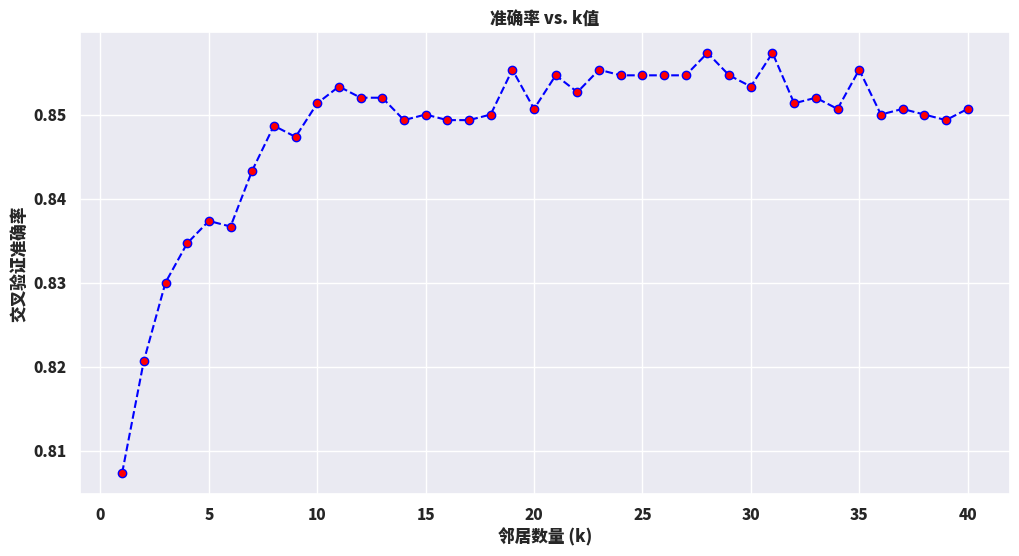

In [17]:
# --- Example 8 ---
# --- 使用GridSearchCV寻找最优$k$ ---
# 定义要搜索的参数网格
param_grid = {'n_neighbors': np.arange(1, 41)} # 测试k从1到40

# 设置GridSearchCV对象
knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5, # 5折交叉验证
    scoring='accuracy',
    verbose=1
)

# 在训练数据上拟合网格搜索
knn_grid.fit(X_train_scaled, y_train)

# 获取最佳参数
best_k = knn_grid.best_params_['n_neighbors']
print(f"\nGridSearchCV找到的最优$k$值: {best_k}")
print(f"最佳交叉验证准确率: {knn_grid.best_score_:.4f}")

# --- 绘制网格搜索的结果 ---
cv_results = pd.DataFrame(knn_grid.cv_results_)
plt.figure(figsize=(12, 6))
plt.plot(cv_results['param_n_neighbors'], cv_results['mean_test_score'], marker='o',
         linestyle='dashed', color='blue', markerfacecolor='red')
plt.title('准确率 vs. k值')
plt.xlabel('邻居数量 (k)')
plt.ylabel('交叉验证准确率')
plt.grid(True)
plt.show()


--- 最终模型评估 (k=31) ---
              precision    recall  f1-score   support

         未流失       0.88      0.95      0.91       380
          流失       0.78      0.60      0.68       120

    accuracy                           0.86       500
   macro avg       0.83      0.77      0.80       500
weighted avg       0.86      0.86      0.86       500



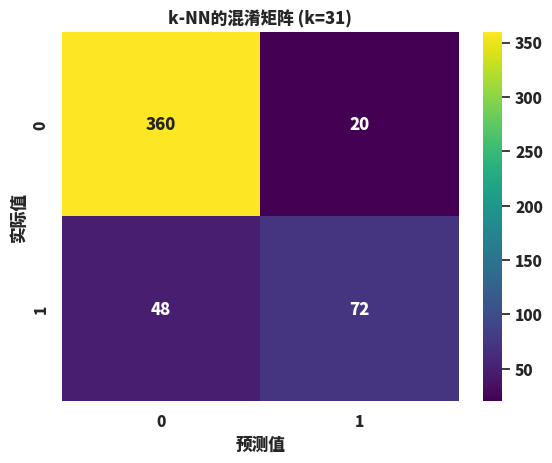

In [18]:
# --- Example 9 ---
# --- 使用最优$k$训练最终模型 ---
best_knn = knn_grid.best_estimator_ # 这是用最佳$k$训练好的模型

# --- 在测试集上进行预测 ---
y_pred_knn = best_knn.predict(X_test_scaled)

# --- 评估最终模型 ---
print("\n--- 最终模型评估 (k=" + str(best_k) + ") ---")
print(classification_report(y_test, y_pred_knn, target_names=['未流失', '流失']))

# 可视化混淆矩阵
cm = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title(f'k-NN的混淆矩阵 (k={best_k})')
plt.ylabel('实际值')
plt.xlabel('预测值')
plt.show()

简单的决策树 (max_depth=3) 已训练完成。


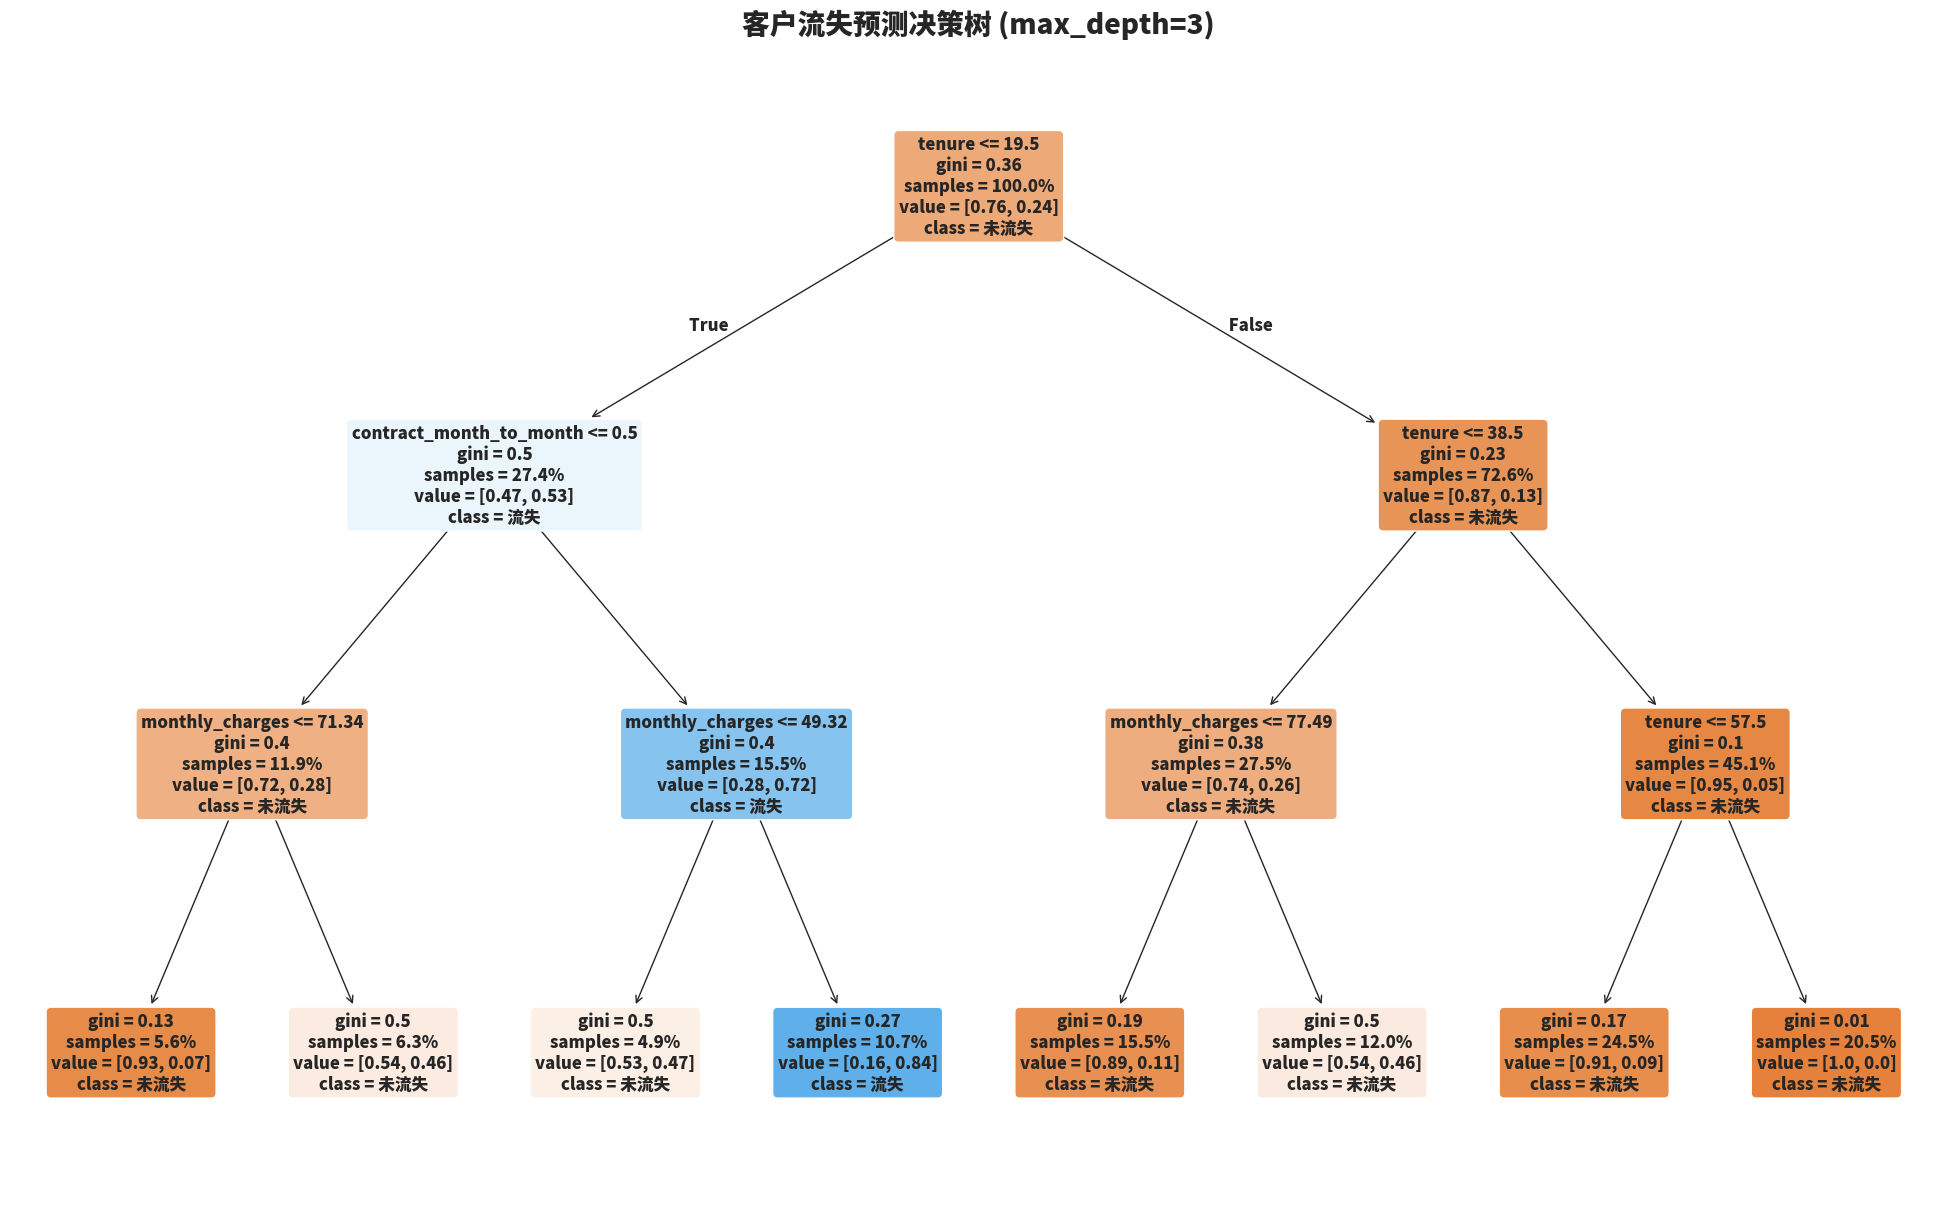

In [19]:
# --- Example 10 ---
# --- 导入库 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix

# 假设 'df' 是在之前章节中生成的DataFrame
X = df.drop('churn', axis=1)
y = df['churn']

# --- 使用原始、未缩放的数据以保证可解释性 ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# --- 训练一个简单的、经过剪枝的决策树用于可视化 ---
# 我们设置 max_depth=3 以便理解
dt_simple = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_simple.fit(X_train, y_train)

print("简单的决策树 (max_depth=3) 已训练完成。")

# --- 可视化决策树 ---
plt.figure(figsize=(25, 15))
plot_tree(
    dt_simple,
    feature_names=X.columns,
    class_names=['未流失', '流失'],
    filled=True,      # 按多数类别给节点着色
    rounded=True,     # 使用圆角矩形
    fontsize=12,
    proportion=True,  # 显示比例而非原始计数
    precision=2
)
plt.title("客户流失预测决策树 (max_depth=3)", fontsize=20)
plt.show()

In [21]:
# --- Example 11 (可运行微修版) ---
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# --- 定义用于调优的参数网格 ---
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10],   # ← 补上最小分裂样本数的候选值（最小改动）
    'min_samples_leaf': [1, 2, 4],
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01]  # 成本复杂度剪枝参数
}

# --- 设置并运行网格搜索 ---
dt = DecisionTreeClassifier(random_state=42)
grid_search_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid_dt,
    cv=5,
    scoring='f1',   # 以F1分数为优化目标
    n_jobs=-1,      # 使用所有可用CPU核心
    verbose=1
)

grid_search_dt.fit(X_train, y_train)

# --- 获取最佳模型和参数 ---
best_dt = grid_search_dt.best_estimator_
print(f"\nGridSearchCV找到的最佳参数: {grid_search_dt.best_params_}")

# --- 评估调优后的模型 ---
y_pred_best_dt = best_dt.predict(X_test)
print("\n--- 调优后决策树的评估报告 ---")
print(classification_report(y_test, y_pred_best_dt, target_names=['未流失', '流失']))


Fitting 5 folds for each of 432 candidates, totalling 2160 fits

GridSearchCV找到的最佳参数: {'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2}

--- 调优后决策树的评估报告 ---
              precision    recall  f1-score   support

         未流失       0.89      0.89      0.89       380
          流失       0.66      0.65      0.65       120

    accuracy                           0.83       500
   macro avg       0.77      0.77      0.77       500
weighted avg       0.83      0.83      0.83       500



/var/folders/rj/649h7g4n067cz93vfqs350lm0000gn/T/ipykernel_69586/3974279251.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


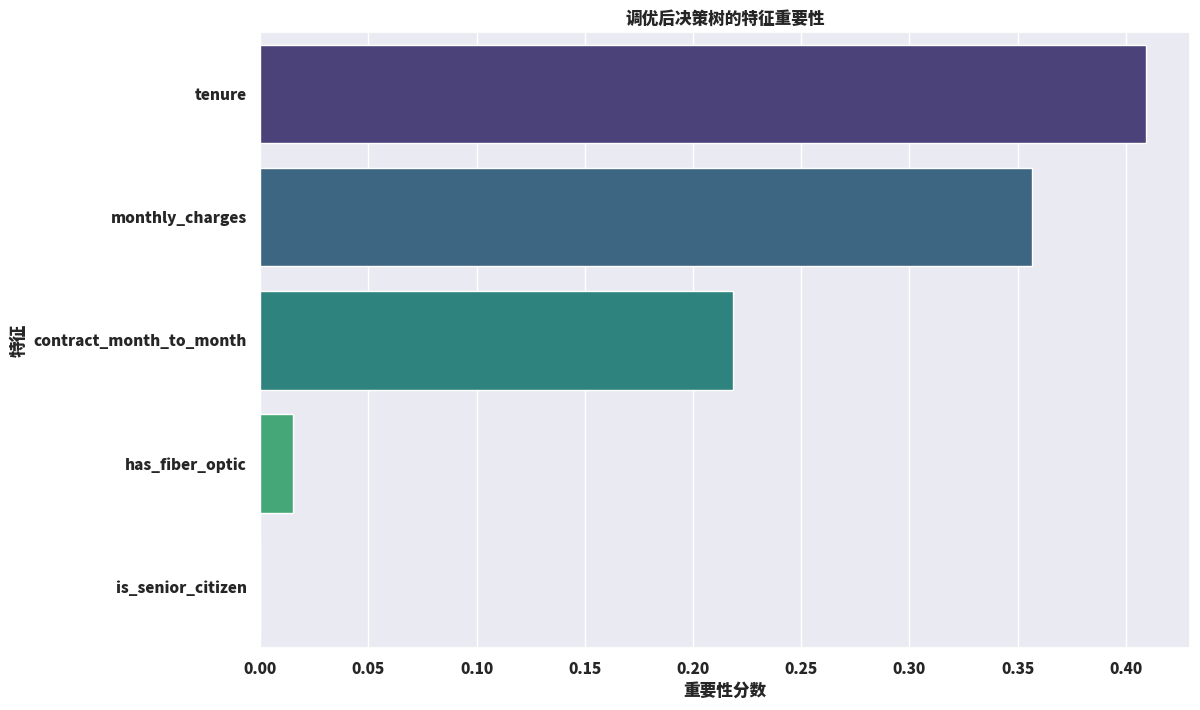


--- 特征重要性排名 ---
                   Feature  Importance
0                   tenure    0.409236
1          monthly_charges    0.356786
3  contract_month_to_month    0.218560
4          has_fiber_optic    0.015419
2        is_senior_citizen    0.000000


In [23]:
# --- Example 12 ---
# --- 从调优后的模型中获取并绘制特征重要性 ---
importances = best_dt.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('调优后决策树的特征重要性')
plt.xlabel('重要性分数')
plt.ylabel('特征')
plt.show()

print("\n--- 特征重要性排名 ---")
print(feature_importance_df)

In [25]:
# --- Example 13 ---
# --- 导入库 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 假设 'df' 是在之前章节中生成的DataFrame
X = df.drop('churn', axis=1)
y = df['churn']

# --- 使用原始、未缩放的数据 ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# --- 训练一个带默认参数和OOB分数的随机森林 ---
# n_estimators是森林中树的数量。
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True, n_jobs=-1)
rf_clf.fit(X_train, y_train)

print("包含100棵树的随机森林模型已训练完成。")
print(f"袋外（OOB）分数: {rf_clf.oob_score_:.4f}")

# --- 评估模型 ---
y_pred_rf = rf_clf.predict(X_test)
print("\n--- 基准随机森林的评估 ---")
print(classification_report(y_test, y_pred_rf, target_names=['未流失', '流失']))

包含100棵树的随机森林模型已训练完成。
袋外（OOB）分数: 0.8360

--- 基准随机森林的评估 ---
              precision    recall  f1-score   support

         未流失       0.87      0.91      0.89       380
          流失       0.67      0.57      0.62       120

    accuracy                           0.83       500
   macro avg       0.77      0.74      0.75       500
weighted avg       0.82      0.83      0.83       500



/var/folders/rj/649h7g4n067cz93vfqs350lm0000gn/T/ipykernel_69586/3695958512.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')


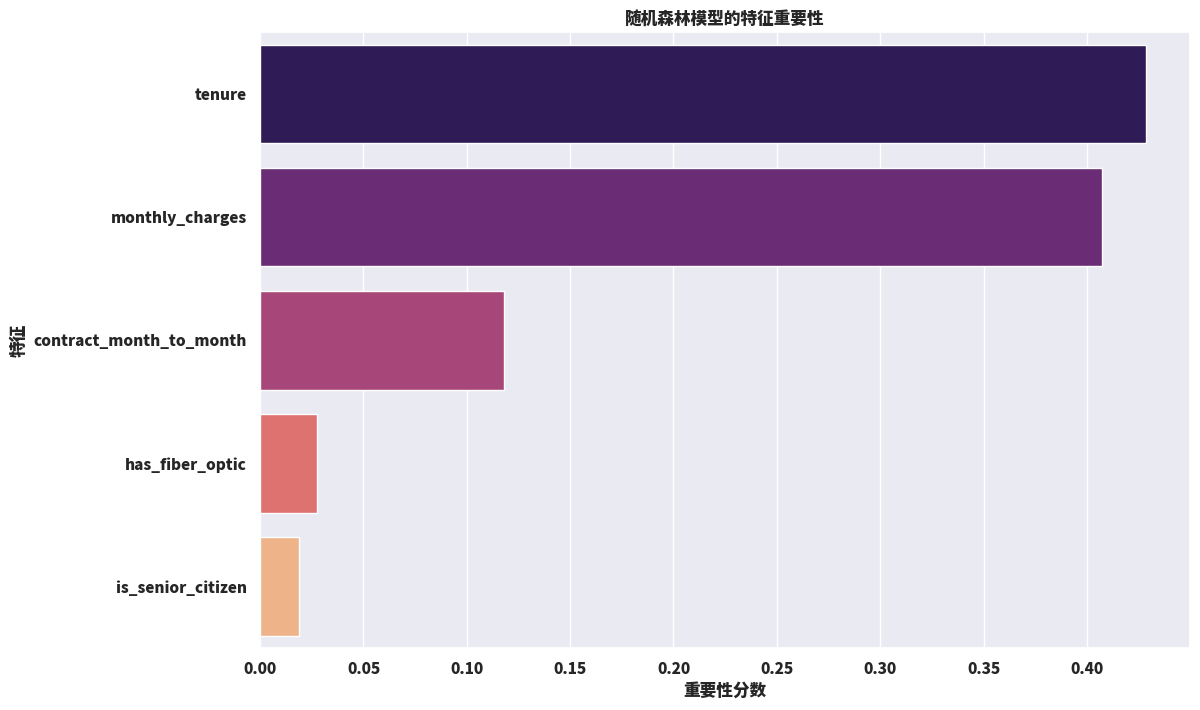


--- 特征重要性排名（随机森林） ---
                   Feature  Importance
0                   tenure    0.428530
1          monthly_charges    0.407378
3  contract_month_to_month    0.117894
4          has_fiber_optic    0.027388
2        is_senior_citizen    0.018810


In [26]:
# --- Example 14 ---
# --- 获取并绘制特征重要性 ---
importances = rf_clf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')
plt.title('随机森林模型的特征重要性')
plt.xlabel('重要性分数')
plt.ylabel('特征')
plt.show()

print("\n--- 特征重要性排名（随机森林） ---")
print(feature_importance_df)

In [27]:
# --- Example 15 ---
# --- 定义一个较小的参数网格以便快速搜索 ---
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# --- 设置并运行网格搜索 ---
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, oob_score=True),
    param_grid=param_grid_rf,
    cv=3, # 为了速度使用3折交叉验证
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_search_rf.fit(X_train, y_train)

# --- 获取最佳模型 ---
best_rf = grid_search_rf.best_estimator_
print(f"\n找到的最佳参数: {grid_search_rf.best_params_}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits

找到的最佳参数: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 300}


In [28]:
# --- Example 16 ---
# --- 导入库 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 假设 'df' 是在之前章节中生成的DataFrame
X = df.drop('churn', axis=1)
y = df['churn']

# --- 拆分和缩放数据 ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 训练一个使用RBF核的基准SVM ---
# probability=True 用于获取概率估计，但这会减慢训练速度
svm_clf = SVC(kernel='rbf', random_state=42, probability=True)
svm_clf.fit(X_train_scaled, y_train)

# --- 评估基准模型 ---
y_pred_svm = svm_clf.predict(X_test_scaled)
print("--- 基准SVM分类报告 ---")
print(classification_report(y_test, y_pred_svm, target_names=['未流失', '流失']))

--- 基准SVM分类报告 ---
              precision    recall  f1-score   support

         未流失       0.88      0.94      0.91       380
          流失       0.77      0.59      0.67       120

    accuracy                           0.86       500
   macro avg       0.83      0.77      0.79       500
weighted avg       0.85      0.86      0.85       500



In [29]:
# --- Example 17 ---
# --- 定义参数网格 ---
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

# --- 设置并运行网格搜索 ---
grid_svm = GridSearchCV(
    SVC(random_state=42, probability=True),
    param_grid_svm,
    refit=True, # 自动在整个训练集上重新拟合最佳模型
    verbose=2,
    cv=3, # 3折交叉验证
    scoring='f1'
)

grid_svm.fit(X_train_scaled, y_train)

# --- 获取最佳模型并进行评估 ---
best_svm = grid_svm.best_estimator_
print(f"\n找到的最佳参数: {grid_svm.best_params_}")
y_pred_best_svm = best_svm.predict(X_test_scaled)
print("\n--- 优化后SVM的分类报告 ---")
print(classification_report(y_test, y_pred_best_svm, target_names=['未流失', '流失']))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=0.001

In [21]:
# --- Example 18 ---
# --- 导入库 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# 假设 'df' 是在之前章节中生成的DataFrame
X = df.drop('churn', axis=1)
y = df['churn']

# --- 拆分和缩放数据 ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 定义模型及其超参数网格 ---
models_and_params = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {'C': [0.1, 1, 10]}
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {'max_depth': [5, 10, None], 'min_samples_leaf': [1, 2, 4]}
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, None]}
    },
    'SVM': {
        'model': SVC(random_state=42, probability=True),
        'params': {'C': [0.1, 1, 10], 'gamma': [0.1, 0.01]}
    }
}

# --- 训练、调优和评估每个模型 ---
results = []
for name, mp in models_and_params.items():
    # 为LR和SVM使用缩放数据，为树模型使用未缩放数据
    if name in ['Logistic Regression', 'SVM']:
        X_train_data, X_test_data = X_train_scaled, X_test_scaled
    else:
        # 如果需要，将树模型的数据转回DataFrame
        X_train_data = pd.DataFrame(X_train, columns=X.columns)
        X_test_data = pd.DataFrame(X_test, columns=X.columns)

    # 网格搜索最佳参数
    grid = GridSearchCV(mp['model'], mp['params'], cv=StratifiedKFold(n_splits=3), scoring='f1')
    grid.fit(X_train_data, y_train)
    best_model = grid.best_estimator_
    
    # 进行预测和评估
    y_pred = best_model.predict(X_test_data)
    y_proba = best_model.predict_proba(X_test_data)[:, 1] if hasattr(best_model, "predict_proba") else [0.5]*len(y_pred)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Accuracy': accuracy,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })

# --- 显示结果 ---
results_df = pd.DataFrame(results).sort_values(by='F1-Score', ascending=False)
print("\n--- 模型比较结果 ---")
print(results_df)


--- 模型比较结果 ---
                 Model                              Best Params  Accuracy  \
0  Logistic Regression                                 {'C': 1}     0.864   
3                  SVM                 {'C': 10, 'gamma': 0.01}     0.866   
2        Random Forest   {'max_depth': 10, 'n_estimators': 200}     0.822   
1        Decision Tree  {'max_depth': 5, 'min_samples_leaf': 2}     0.836   

   F1-Score   ROC-AUC  
0  0.693694  0.922763  
3  0.691244  0.925811  
2  0.593607  0.890373  
1  0.581633  0.879320  
